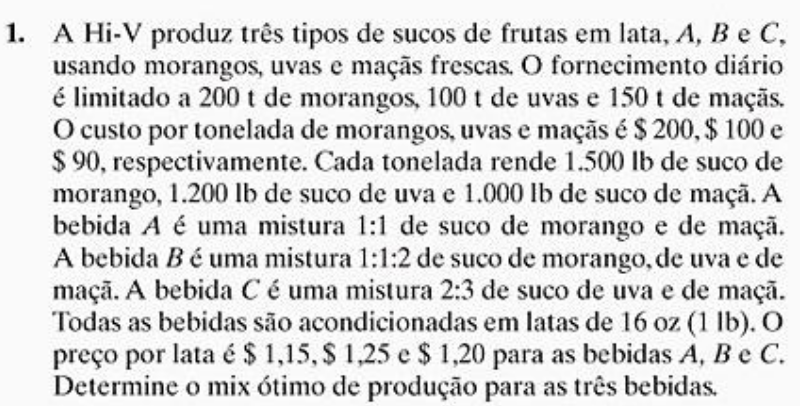

In [1]:
%pip install cplex
%pip install docplex

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
from docplex.mp.model import Model

# Criação do modelo com um nome descritivo
model = Model('Producao_Sucos_HiV')

In [3]:
# --- Parâmetros extraídos do enunciado ---

# Matérias-primas (Frutas) e Produtos Finais (Bebidas)
frutas = ['morango', 'uva', 'maca']
bebidas = ['A', 'B', 'C']

# Disponibilidade diária e custo das frutas
disponibilidade_fruta_ton = {'morango': 200, 'uva': 100, 'maca': 150}
custo_fruta_ton = {'morango': 200, 'uva': 100, 'maca': 90}

# Rendimento de suco (lb de suco por tonelada de fruta)
rendimento_suco_lb_ton = {'morango': 1500, 'uva': 1200, 'maca': 1000}

# Preço de venda por lata (1 lb) de cada bebida
preco_bebida_lb = {'A': 1.15, 'B': 1.25, 'C': 1.20}

# Composição das bebidas (fração de cada suco)
composicao_bebida = {
    'A': {'morango': 0.50, 'uva': 0.00, 'maca': 0.50},
    'B': {'morango': 0.25, 'uva': 0.25, 'maca': 0.50},
    'C': {'morango': 0.00, 'uva': 0.40, 'maca': 0.60}
}

In [4]:
# 1. Variáveis de Decisão
# Toneladas de cada fruta a serem compradas
toneladas_fruta = model.continuous_var_dict(frutas, name='Fruta_ton')

# Libras (lbs) de cada bebida a serem produzidas (1 lb = 1 lata)
libras_bebida = model.continuous_var_dict(bebidas, name='Bebida_lb')


# 2. Função Objetivo
# Maximizar o Lucro Total = (Receita das Bebidas) - (Custo das Frutas)
expressao_receita = (preco_bebida_lb[b] * libras_bebida[b] for b in bebidas)
receita_total = model.sum(expressao_receita)

expressao_custo = (custo_fruta_ton[f] * toneladas_fruta[f] for f in frutas)
custo_total = model.sum(expressao_custo)

lucro_total = receita_total - custo_total
model.maximize(lucro_total)


# 3. Restrições

# Restrição 1: Disponibilidade de Frutas
# A quantidade de cada fruta comprada não pode exceder a disponibilidade diária.
for f in frutas:
    restr_disponibilidade_logica = toneladas_fruta[f] <= disponibilidade_fruta_ton[f]
    model.add_constraint(restr_disponibilidade_logica, ctname=f'disponibilidade_{f}')

# Restrição 2: Balanço de Suco
# Para cada tipo de suco, a quantidade usada nas bebidas não pode exceder a quantidade produzida.
# Suco Usado <= Suco Produzido (Rendimento * Fruta)
for f in frutas: # O loop passa por 'morango', 'uva', 'maca'
    expressao_suco_usado = (composicao_bebida[b][f] * libras_bebida[b] for b in bebidas)
    soma_suco_usado = model.sum(expressao_suco_usado)
    
    suco_produzido = rendimento_suco_lb_ton[f] * toneladas_fruta[f]
    
    restr_balanco_suco_logica = soma_suco_usado <= suco_produzido
    model.add_constraint(restr_balanco_suco_logica, ctname=f'balanco_suco_{f}')

In [5]:
# Define um tempo limite para o solver (opcional)
model.parameters.timelimit = 120

# Aciona o solver para encontrar a solução
print("--- Resolvendo o modelo ---")
solucao = model.solve(log_output=True)

print('\n------ SOLUÇÃO ÓTIMA ------\n')
if solucao:
    lucro_maximo = model.objective_value
    print(f"Lucro Diário Máximo: ${lucro_maximo:,.2f}\n")

    print("--- Plano de Compra de Frutas (toneladas) ---")
    for f in frutas:
        fruta_val = toneladas_fruta[f].solution_value
        if fruta_val > 1e-6:
            print(f"  - {f.capitalize()}: {fruta_val:,.2f} toneladas")

    print("\n--- Plano de Produção de Bebidas (latas de 1lb) ---")
    for b in bebidas:
        bebida_val = libras_bebida[b].solution_value
        if bebida_val > 1e-6:
            print(f"  - Bebida {b}: {bebida_val:,.2f} latas")
else:
    print("Não foi possível encontrar uma solução.")

--- Resolvendo o modelo ---
Version identifier: 22.1.2.0 | 2024-12-10 | f4cec290b
CPXPARAM_Read_DataCheck                          1
CPXPARAM_TimeLimit                               120
Tried aggregator 1 time.
LP Presolve eliminated 3 rows and 0 columns.
Reduced LP has 3 rows, 6 columns, and 10 nonzeros.
Presolve time = 0.00 sec. (0.00 ticks)

Iteration log . . .
Iteration:     1   Scaled dual infeas =           299.999997

------ SOLUÇÃO ÓTIMA ------

Lucro Diário Máximo: $345,250.00

--- Plano de Compra de Frutas (toneladas) ---
  - Morango: 50.00 toneladas
  - Uva: 62.50 toneladas
  - Maca: 150.00 toneladas

--- Plano de Produção de Bebidas (latas de 1lb) ---
  - Bebida B: 300,000.00 latas
